In [36]:
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import yaml
import pandas as pd
from rasterio.crs import CRS
from tile_mate import get_raster_from_tiles

## Make dry area

In [37]:
bounds_se = [-122.7839,51.8, -122.608, 51.854]

In [38]:
X_esa, p_esa = get_raster_from_tiles(bounds_se, tile_shortname='esa_world_cover_2021')

Reading tile imagery: 100%|██████████████████| 1/1 [00:00<00:00, 831.21it/s]


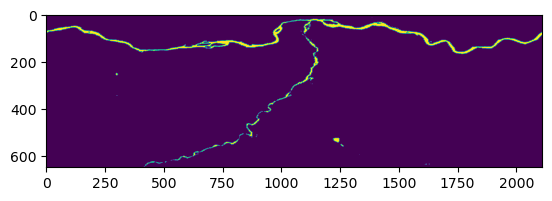

In [39]:
plt.imshow(X_esa[0, ...] ==80)

In [40]:
X_esa_water = (X_esa ==80)

In [41]:
with rasterio.open('water_esa_2021.tif', 'w', **p_esa) as ds:
    ds.write(X_esa_water)

In [42]:
yaml_file = '../events/chilcotin_river_landslide_and_flood_2024.yml' #'porto_algre.yml'
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'chilcotin_river_landslide_and_flood_2024',
 'bounds': [-122.92087775, 51.83943495, -122.69035819, 51.88365439],
 'event_date': '2024-07-30',
 'pre_event_window_days': 100,
 'post_event_window_days': 60,
 'rtc_track_numbers': [13, 137],
 'mgrs_tiles': ['10UEC'],
 'dist_hls_confirmed_change_min_days': 15,
 'source_id': 'Al Handwerger derived landslide and flood from Planet 3m; dry areas from HLS and ESA world cover by Charlie Marshak',
 'links': ['https://chilcotin-river-landslide-2024-bcgov03.hub.arcgis.com/',
  'https://www.bluemarble.nasa.gov/images/153195/chilcotin-rivers-landslide-lake-begins-draining']}

In [43]:
paths = ['../external_validation_data/chilcotin_landslide_2024/landslide_shapefile/BC_inunudated_2024.shp',
         '../external_validation_data/chilcotin_landslide_2024/landslide_shapefile/downstream_dry.shp',
         '../external_validation_data/chilcotin_landslide_2024/landslide_shapefile/BC_Landslide_2024.shp']
aoi_path = '../external_validation_data/chilcotin_landslide_2024/landslide_shapefile/aoi.shp'

In [44]:
dfs = [gpd.read_file(p).to_crs(4326) for p in paths]
df_event = pd.concat(dfs, axis=0)
df_event.head()

,id,geometry
0,None,"POLYGON ((-122.79236 51.84643, -122.79348 51.8..."
0,0,"POLYGON ((-122.78179 51.84859, -122.78118 51.8..."
1,1,"POLYGON ((-122.78108 51.84839, -122.78108 51.8..."
2,1,"POLYGON ((-122.77572 51.84956, -122.77336 51.8..."
3,1,"POLYGON ((-122.77336 51.84977, -122.77204 51.8..."


<Axes: >

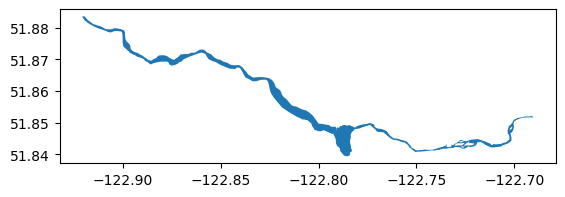

In [45]:
df_event.plot()

In [46]:
geo = df_event.geometry.unary_union

df_event_f = gpd.GeoDataFrame({'name': [event_dict['event_name']],
                               'date': [pd.to_datetime(event_dict['event_date'])],
                               'source_id': [f'{event_dict["source_id"]}']},
                              geometry=[geo],
                              crs=CRS.from_epsg(4326))
df_event_f.head()

,name,date,source_id,geometry
0,chilcotin_river_landslide_and_flood_2024,2024-07-30,Al Handwerger derived landslide and flood from...,"MULTIPOLYGON (((-122.74892 51.84087, -122.7488..."


In [47]:
EXTERNAL_VAL_DATA_DIR = Path('../external_validation_data_db/')
EXTERNAL_VAL_DATA_DIR.mkdir(exist_ok=True, parents=True)

In [48]:
df_event_f.to_file(EXTERNAL_VAL_DATA_DIR / f'{event_dict["event_name"]}.geojson', driver='GeoJSON')

# Extent

In [49]:
from shapely import convex_hull 
df_aoi = gpd.read_file(aoi_path)


<Axes: >

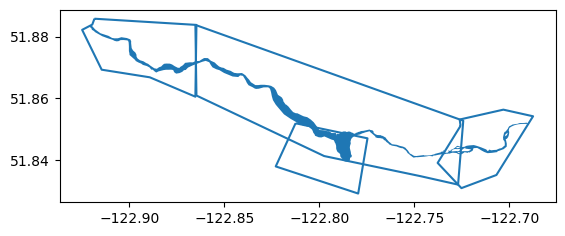

In [50]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
df_aoi.boundary.plot(ax=ax)
df_event_f.plot(ax=ax)

In [51]:
EXTERNAL_VAL_EXTENTS = Path('../external_validation_data_extents_db/')
EXTERNAL_VAL_EXTENTS.mkdir(exist_ok=True, parents=True)

df_aoi.to_file(EXTERNAL_VAL_EXTENTS / f'{event_dict["event_name"]}.geojson', driver='GeoJSON')